<a href="https://colab.research.google.com/github/ghoultay/Segmenatation_models_analysisnalisys/blob/main/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kanametov/ph2dataset

100% 203M/203M [00:10<00:00, 22.6MB/s]
100% 203M/203M [00:10<00:00, 20.1MB/s]


In [ ]:
! unzip "ph2dataset.zip"

Archive:  ph2dataset.zip
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_lesion/IMD002_lesion.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_roi/IMD002_R1_Label4.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD002/IMD002_roi/IMD002_R2_Label3.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD003/IMD003_lesion/IMD003_lesion.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD003/IMD003_roi/IMD003_R1_Label4.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_Dermoscopic_Image/IMD004.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_lesion/IMD004_lesion.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_roi/IMD004_R1_Label4.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD004/IMD004_roi/IMD004_R2_Label3.bmp  
  inflating: PH2Dataset/PH2_Dataset/IMD006/IMD006_Dermoscopic_Image/IMD006.bmp  
  inflating: PH2Dataset/PH2_Dataset

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# if the link has too many requests, the dataset can be downloaded from kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2023-12-04 14:34:08--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-12-04 14:34:08--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 429 Too Many Requests
2023-12-04 14:34:11 ERROR 429: Too Many Requests.



In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
!ls

kaggle.json  PH2Dataset  ph2dataset.zip  sample_data


The stucture of the dataset we have is as follows::

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

There `X.bmp` — the image to be segmented,
`X_lesion.bmp` — segmentation result.

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images have different sizes. Let's resize them to $256\times256 $ pixels.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

To make sure everything is correct, we will draw some images

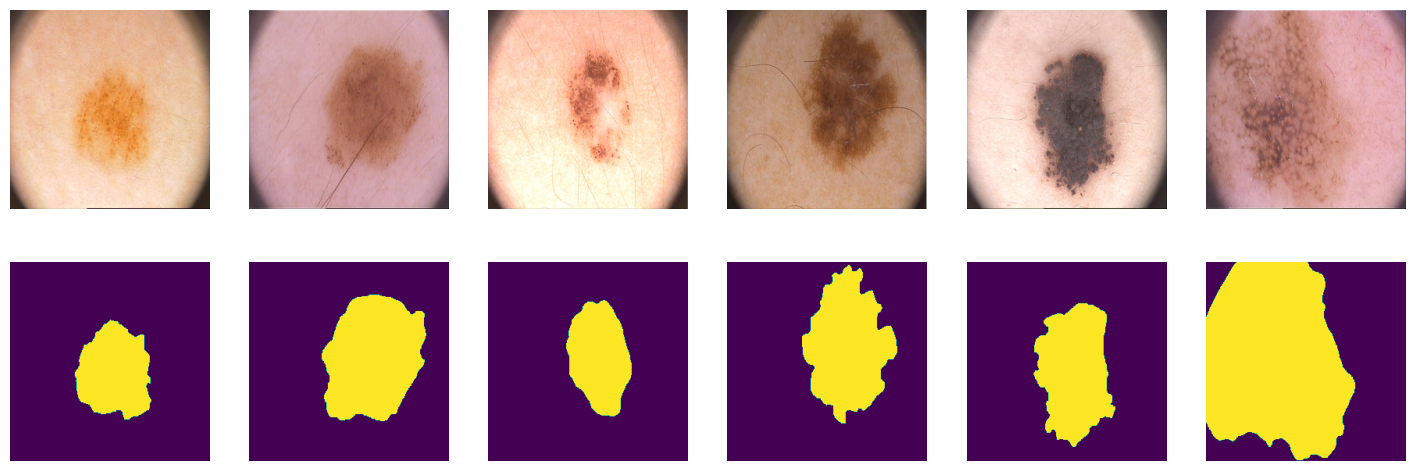

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

We'll divide our 200 images into 100/50/50s
 for training, validation and test respectively

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Realization of different architectures:


-----------------------------------------------------------------------------------------

# SegNet

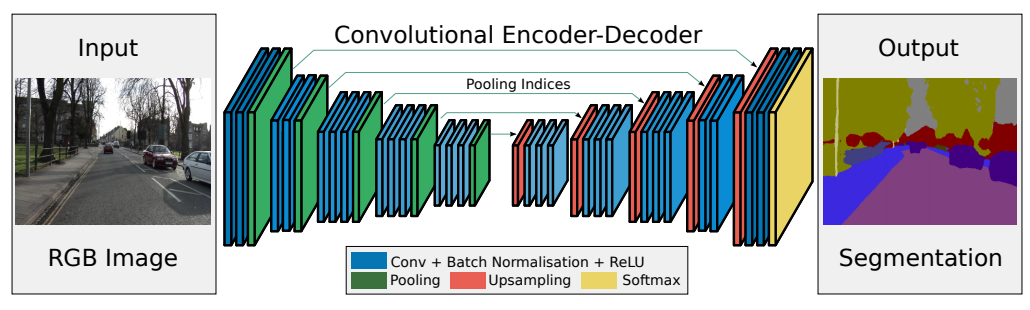

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

res_table = pd.DataFrame(columns = ['Model', 'Loss func' ,'tr_loss', 'val_loss', 'ts_loss'])

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1)
        )
        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)# 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),

            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0))  # no activation
        return d3

## Metric

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the main truth mask, whereas the union (A ∪ B) simply consists of all pixels found in either the prediction mask or the target mask.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, treshold=0.5, SMOOTH=1e-8):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()             # BATCH x 1 x H x W => BATCH x H x W
    labels  = labels.squeeze(1).byte()

    inter = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (inter + SMOOTH) / (union + SMOOTH)                       # We avoid 0/0
    # [0, 1] => [-1, 1]
    return torch.clamp(20 * (iou - treshold), 0, 10).ceil() / 10

## Loss Func

A popular method for binary segmentation is *binary cross-entropy*, which is defined as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the target of the desired outcome and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) that converts a real number $\mathbb R$ into a probability $[0,1]$.

However, this loss suffers from numerical instability problems. Most importantly, $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first one and is not as prone to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_pred*y_real + torch.log(1 + torch.exp(-y_pred)))

In [ ]:
target = torch.Tensor(np.random.sample(100).reshape(-1, 1))
input = 0.25 * target

In [ ]:
print(bce_loss(target, input)) # не знаю почему не такой лосс, но формула у меня правильная
print(nn.BCEWithLogitsLoss()(target, input))

tensor(0.6788)
tensor(0.8876)


## Train


In [ ]:
from IPython.display import clear_output
import gc

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    tr_loss = []
    val_loss = []
    if torch.cuda.is_available():
          torch.cuda.empty_cache()
    gc.collect()
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_loss_val = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch,Y_pred)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        tr_loss.append(avg_loss.item())
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:   # testing mode
            with torch.no_grad():
                Y_hat = model(X_batch.to(device)).detach().cpu()# detach and put into cpu
                loss = loss_fn(Y_batch, Y_hat)
                avg_loss_val += loss / len(data_val)
        val_loss.append(avg_loss_val.item())

        Y_hat = model(X_val.to(device)).detach().cpu()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return tr_loss, val_loss

## Inference
Once the model is trained, this feature can be used to predict segmentation on new data:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)).detach().cpu()
        scores += metric(Y_pred>0.5, Y_label).mean().item()

    return scores/len(data)

## Main part

In [ ]:
model = SegNet().to(device)

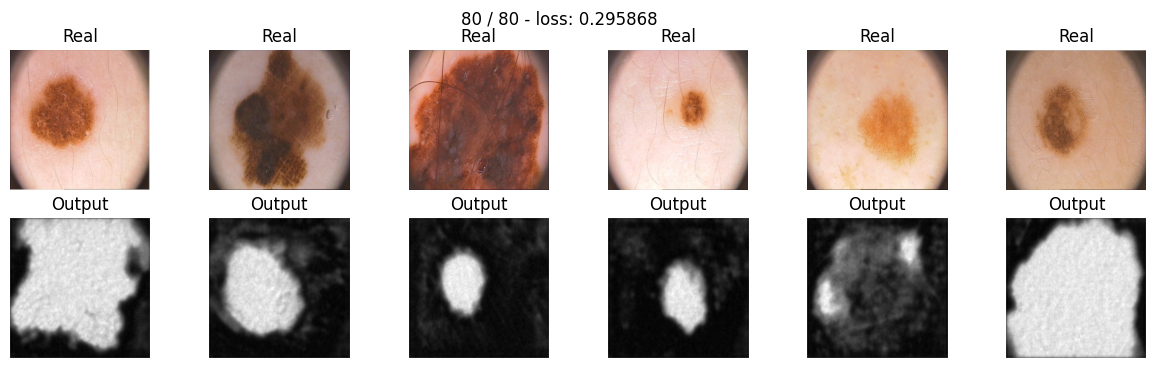

In [ ]:
max_epochs = 80
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.8759999871253967
Validation: 0.7139999568462372
Test: 0.6780000030994415


In [ ]:
res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'bce_loss',
                  'tr_loss': 0.876,	'val_loss': 0.714,	'ts_loss' : 0.678},
                  ignore_index = True)

<ipython-input-16-125fc3d9e4cd>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'bce_loss',


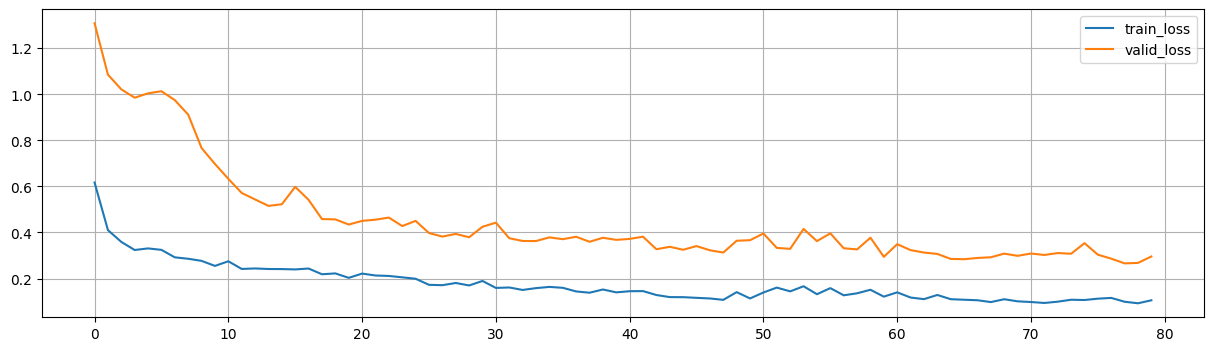

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

From the above graph, there is no discrepancy between train_loss and val_loss, which may mean that the model is not overtrained

-----------------------------------------------------------------------------------------

## Additional loss functions

**1. Dice coefficient:** Given two masks $X$ and $Y$, the general metric for measuring the distance between these two masks is given as follows:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case we can approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    num = torch.sum(y_real*y_pred)
    den = torch.sum(y_real + y_pred)
    res = 1 - (2*num+1)/(den+1)
    return res

In [ ]:
dice_loss(target, input)

tensor(0.4588)

Testing:

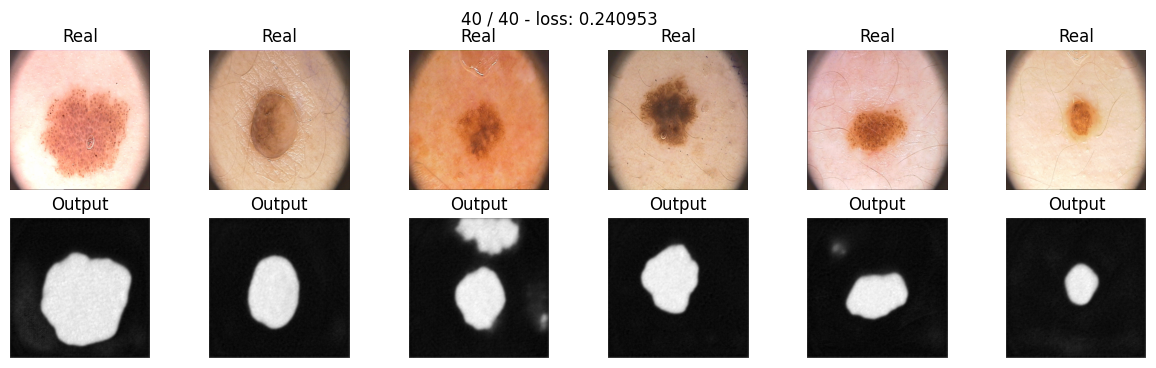

In [ ]:
model = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.8009999841451645
Validation: 0.6899999678134918
Test: 0.7000000178813934


In [ ]:
res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'dice_loss',
                  'tr_loss': 0.801,	'val_loss': 0.690,	'ts_loss' : 0.700},
                  ignore_index = True)

<ipython-input-17-ce0112247c3f>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'dice_loss',


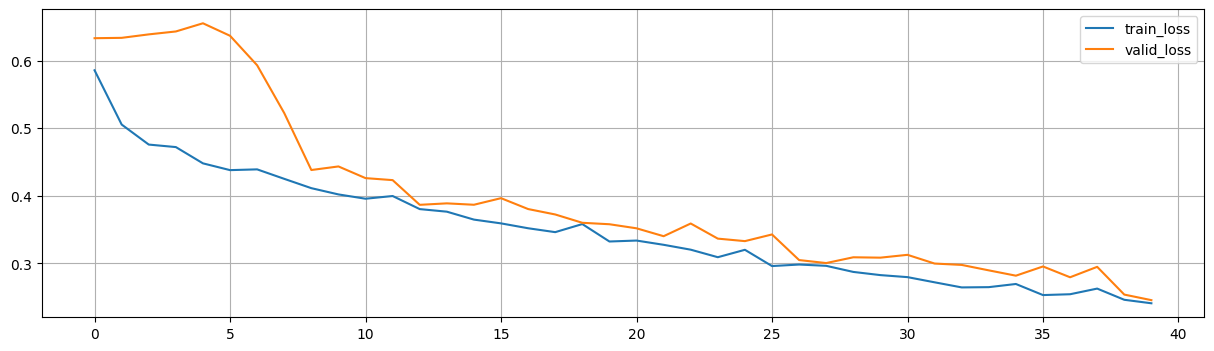

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)


$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to favor the **majority** (background) class over the **majority** ( front) class. Therefore, weights are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $\alpha_i$ is defined as the inverse of the frequency of that pixel's class $i$, so that observations of the minority class weigh more relative to the majority class.

Another recent addition is weighted pixel variant, which weights each pixel by the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's fix the value $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    y_pred = torch.clamp(F.sigmoid(y_pred), min=eps, max=1)
    loss = torch.mean(torch.pow((1-y_pred),gamma) * y_real * torch.log(y_pred) +\
                      (1-y_real) * torch.log(1-y_pred))
    return -loss


In [ ]:
focal_loss(input, target)

tensor(0.8531)

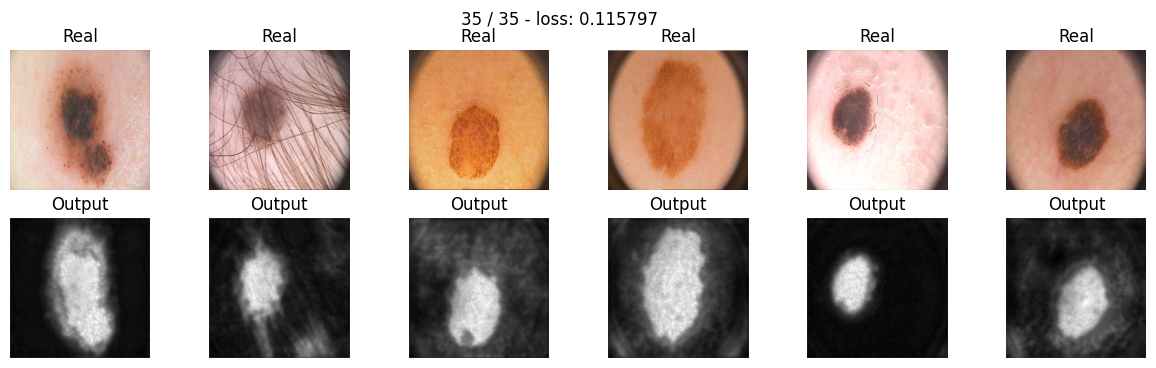

In [ ]:
model = SegNet().to(device)

max_epochs = 35
optimizer = optim.Adam(model.parameters())
tr_loss, val_loss = train(model, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.6899999976158142
Validation: 0.6199999749660492
Test: 0.6020000278949738


In [ ]:
res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'focal_loss',
                  'tr_loss': 0.69,	'val_loss': 0.62,	'ts_loss' : 0.602},
                  ignore_index = True)

<ipython-input-18-83896b396f44>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'focal_loss',


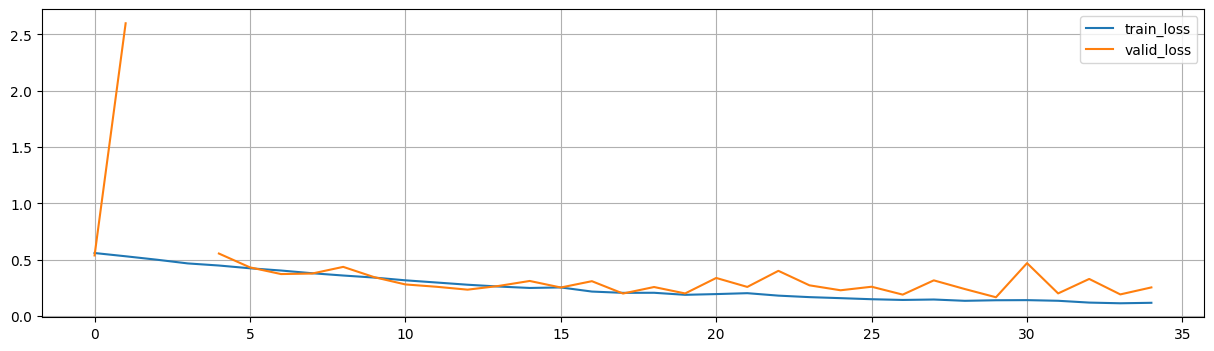

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

----------------------------------------------------------------------------------------------

## SSIM

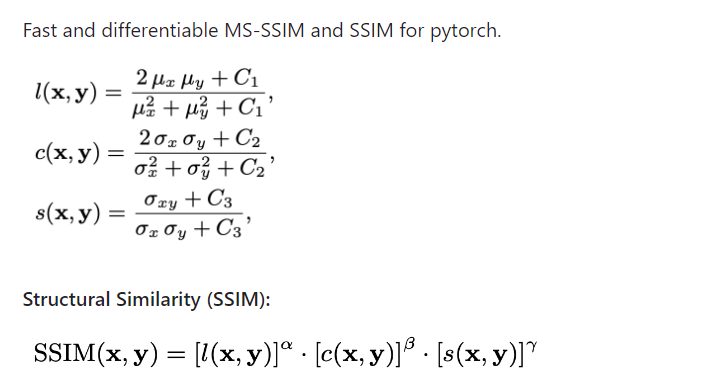

In [ ]:
def ssim_loss(y_real, y_pred, alpha=1, beta=1, gamma=1, c1=1e-8, c2=1e-8, c3=None):

    y_pred = F.sigmoid(y_pred)

    if c3 == None:
      c3 = c2/2

    y_real_mean = y_real.mean()
    y_pred_mean = y_pred.mean()

    y_real_var = y_real.var()
    y_pred_var = y_pred.var()

    covariance = torch.mean((y_pred - y_pred_mean) * (y_real - y_real_mean))

    if c3 == c2/2 and alpha == beta == gamma == 1:

      numerator = (2 * y_real_mean * y_pred_mean + c1) * (2 * covariance + c2)
      denominator = (y_real_mean**2 + y_pred_mean**2 + c1) * \
                    (y_real_var + y_pred_var + c1)

      loss = 1 - numerator/denominator

    else:
      L = (2 * y_real_mean * y_pred_mean + c1) / \
          (y_real_mean**2 + y_pred_mean**2 + c1)

      C = (2 * y_real_var * y_pred_var + c2) / \
          (y_real_var + y_pred_var + c2)

      S = (covariance + c3) / (torch.sqrt(y_real_var * y_pred_var ) + c3)

      loss = (L**alpha) * (C**beta) * (S**gamma)

    return loss

In [ ]:
ssim_loss(input, target)

tensor(0.6376)

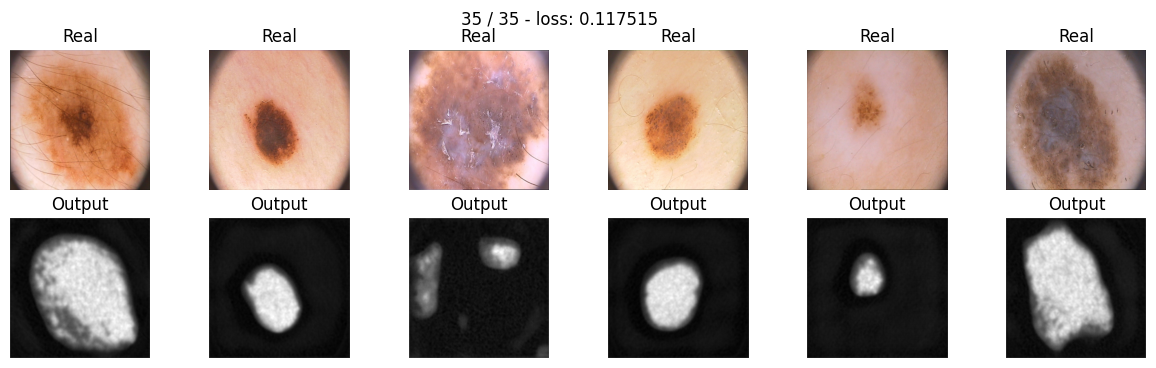

In [ ]:
model = SegNet().to(device)

max_epochs = 35
optimizer = optim.Adam(model.parameters())
tr_loss, val_loss = train(model, optimizer, ssim_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.6190000027418137
Validation: 0.6600000262260437
Test: 0.5840000510215759


In [ ]:
res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'ssim_loss',
                  'tr_loss': 0.619,	'val_loss': 0.66,	'ts_loss' : 0.58},
                  ignore_index = True)

<ipython-input-20-87a4190487af>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'SegNet', 'Loss func' : 'ssim_loss',


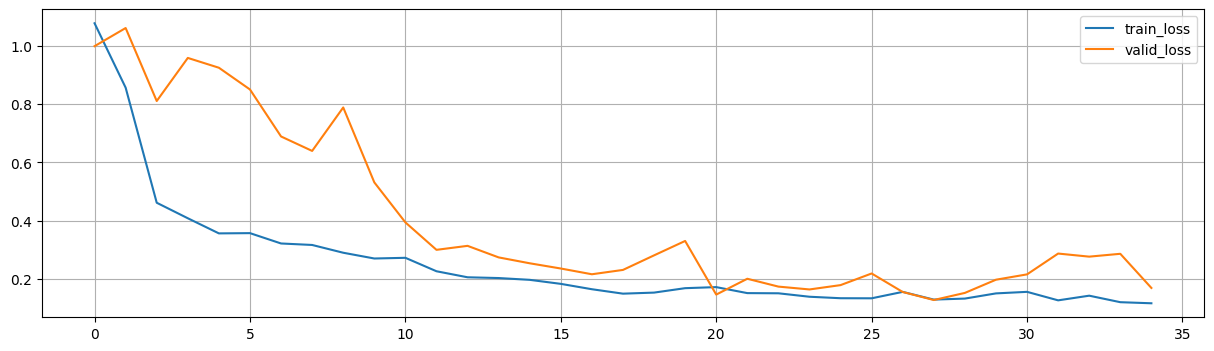

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()

18406


-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/15004597) — is a neural network architecture that takes an image and outputs it. It was originally conceived for semantic segmentation (as we will use it), but it has been so successful that it has since been used in other contexts. Given a medical image as input, it will output a grayscale image where the intensity of each pixel depends on the probability that that pixel belongs to the region of interest.

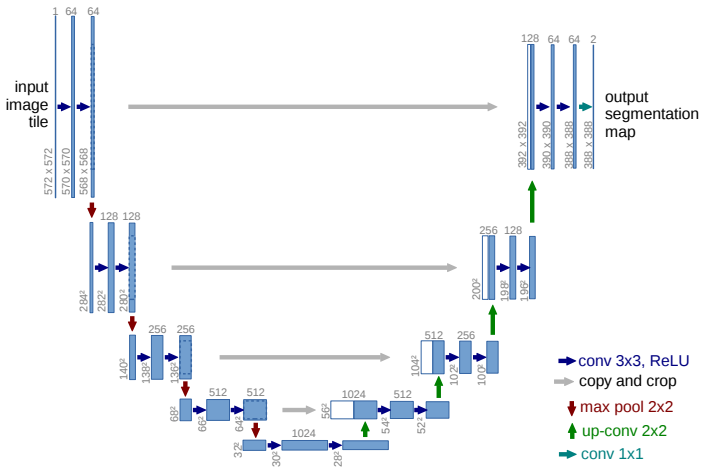

In our architecture we still have encoder and decoder as in **SegNet**, but the distinctive feature of this model is *skip-conenctions* connecting parts of decoder and encoder. That is, in order to pass a tensor to the decoder input, we concatenate the symmetric output from the encoder and the output of the previous decoder layer.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0, idx0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1, idx1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2, idx2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3, idx3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b, idx3)),1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0, idx2)),1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1, idx1)),1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2, idx0)),1))  # no activation
        return d3

In [ ]:
model = UNet().to(device)

In [ ]:
from torchinfo import summary

summary(model, input_size=(batch_size, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [25, 1, 256, 256]         --
├─Sequential: 1-1                        [25, 64, 256, 256]        --
│    └─Conv2d: 2-1                       [25, 64, 256, 256]        1,792
│    └─ReLU: 2-2                         [25, 64, 256, 256]        --
│    └─BatchNorm2d: 2-3                  [25, 64, 256, 256]        128
│    └─Conv2d: 2-4                       [25, 64, 256, 256]        36,928
│    └─ReLU: 2-5                         [25, 64, 256, 256]        --
│    └─BatchNorm2d: 2-6                  [25, 64, 256, 256]        128
├─MaxPool2d: 1-2                         [25, 64, 128, 128]        --
├─Sequential: 1-3                        [25, 128, 128, 128]       --
│    └─Conv2d: 2-7                       [25, 128, 128, 128]       73,856
│    └─ReLU: 2-8                         [25, 128, 128, 128]       --
│    └─BatchNorm2d: 2-9                  [25, 128, 128, 128]       256
│

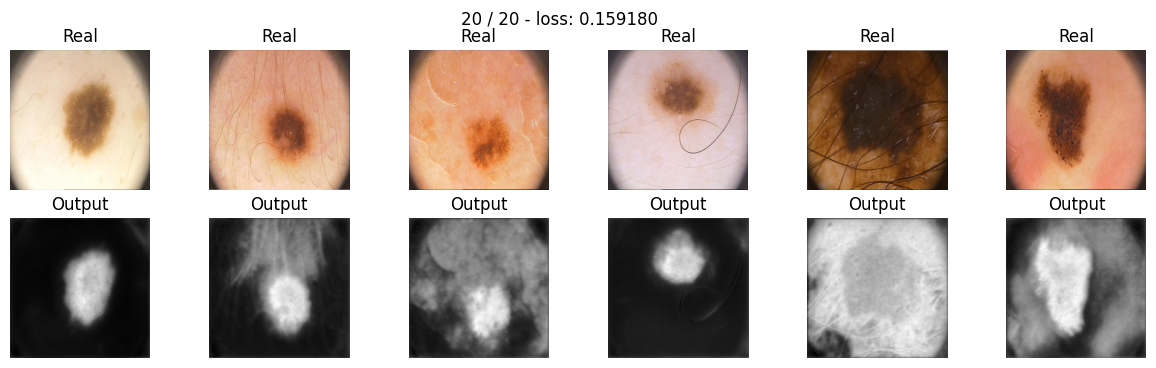

In [ ]:
max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.6849999725818634
Validation: 0.6380000114440918
Test: 0.5580000132322311


In [ ]:
res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'bce_loss',
                  'tr_loss': 0.685,	'val_loss': 0.638,	'ts_loss' : 0.558},
                  ignore_index = True)

<ipython-input-21-c39d37357bae>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'bce_loss',


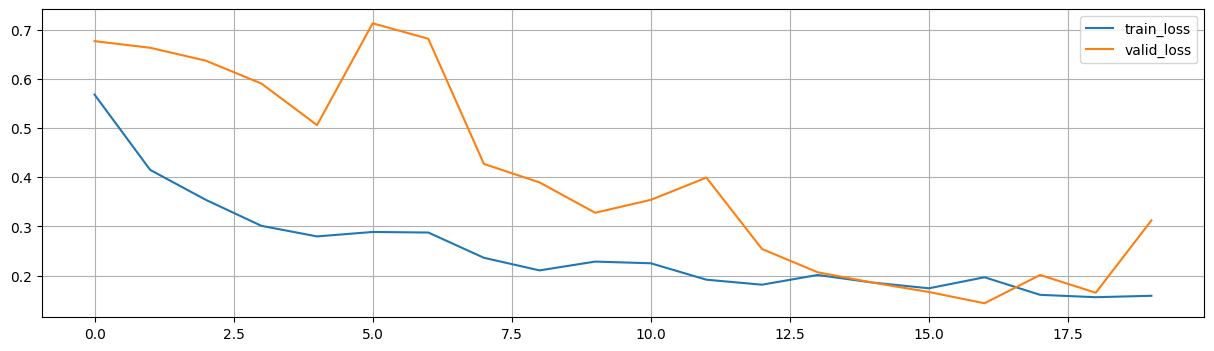

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

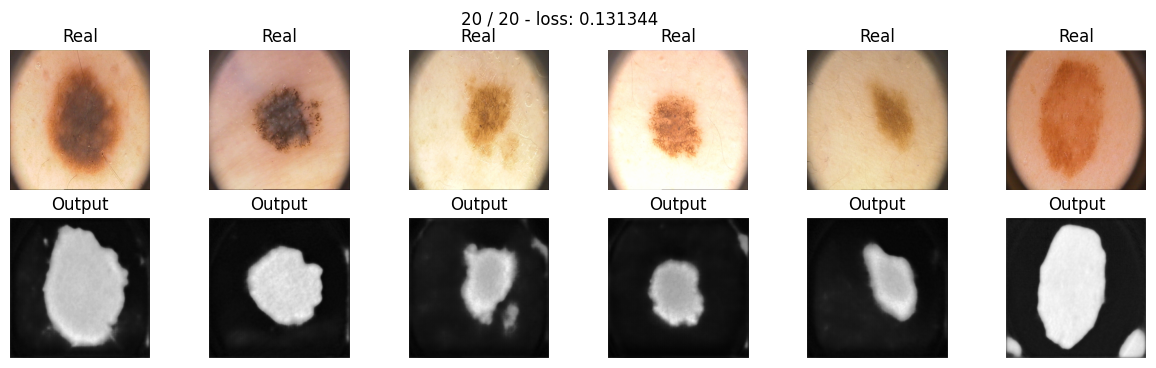

In [ ]:
model = UNet().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.6719999611377716
Validation: 0.6459999978542328
Test: 0.5819999873638153


In [ ]:
res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'dice_loss',
                  'tr_loss': 0.612,	'val_loss': 0.646,	'ts_loss' : 0.582},
                  ignore_index = True)

<ipython-input-22-9bafc19fff81>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'dice_loss',


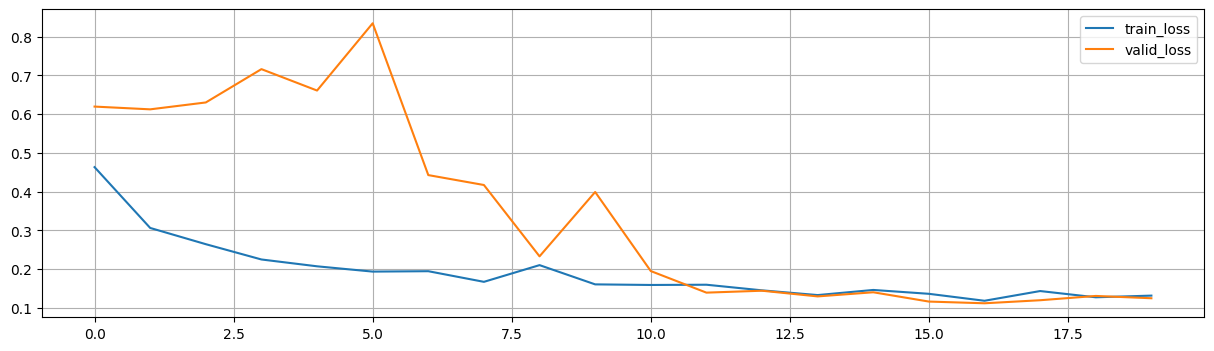

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

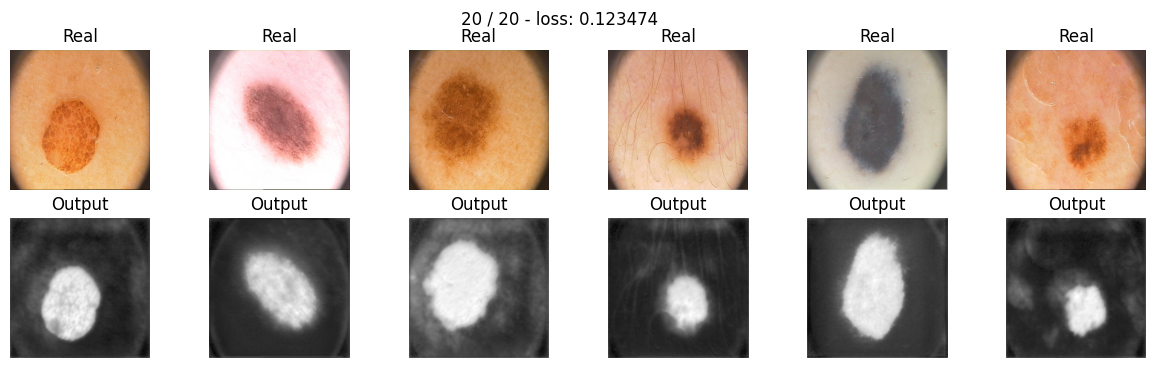

In [ ]:
model = UNet().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.7060000151395798
Validation: 0.7360000312328339
Test: 0.6460000276565552


In [ ]:
res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'focal_loss',
                  'tr_loss': 0.706,	'val_loss': 0.736,	'ts_loss' : 0.646},
                  ignore_index = True)

<ipython-input-23-a225e339fe57>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'bce_loss',


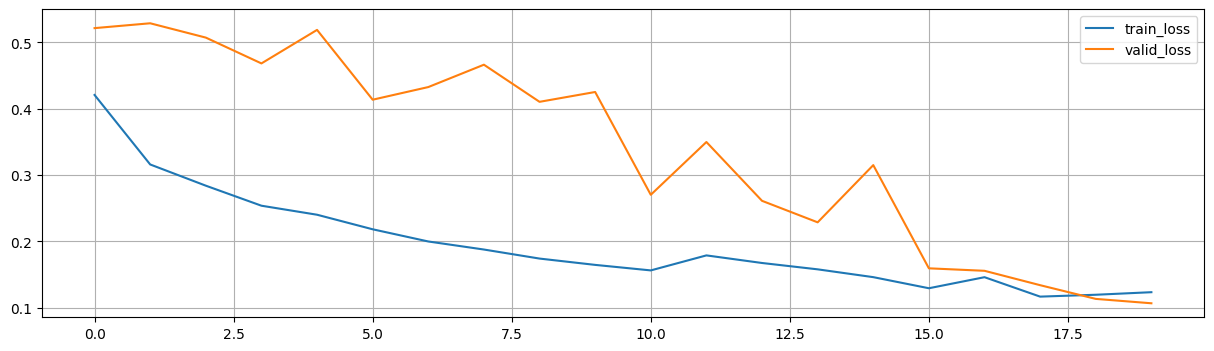

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

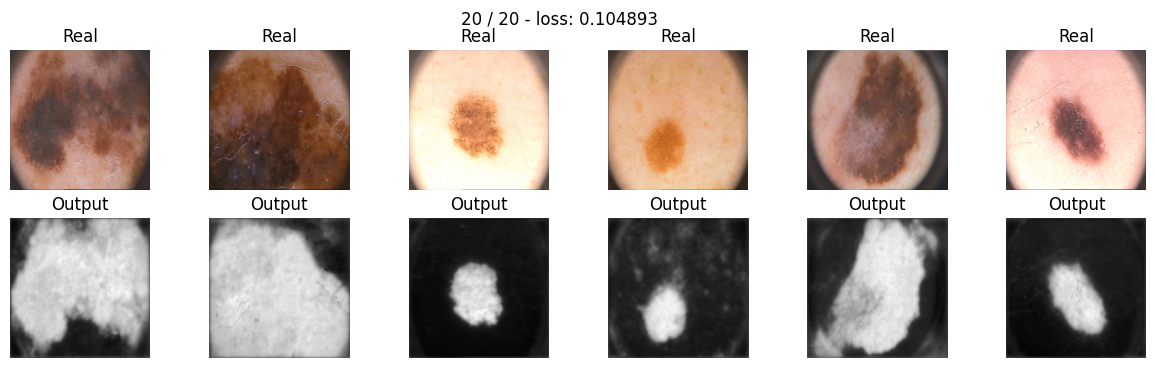

In [ ]:
model = UNet().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, ssim_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.8020000159740448
Validation: 0.7620000243186951
Test: 0.6819999814033508


In [ ]:
res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'ssim_loss',
                  'tr_loss': 0.802,	'val_loss': 0.762,	'ts_loss' : 0.682},
                  ignore_index = True)

<ipython-input-34-8198be6da563>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet', 'Loss func' : 'ssim_loss',


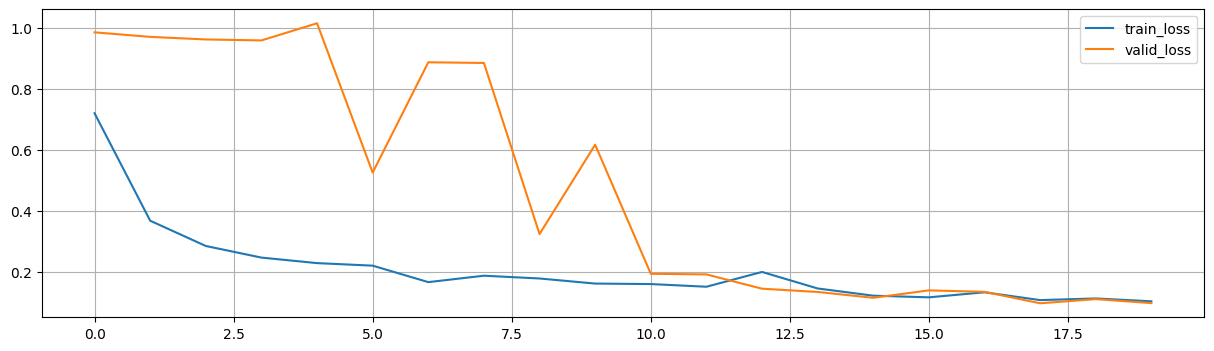

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

New model by changing the type of pooling:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Let's replace max-pooling with convolutions with stride=2 and upsampling with transpose convolutions with stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.Conv2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.upsample1 = nn.ConvTranspose2d(
            in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.upsample2 = nn.ConvTranspose2d(
            in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.upsample3 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b, output_size=e3.size())),1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0,output_size=e2.size())),1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1,output_size=e1.size())),1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2,output_size=e0.size())),1))  # no activation
        return d3

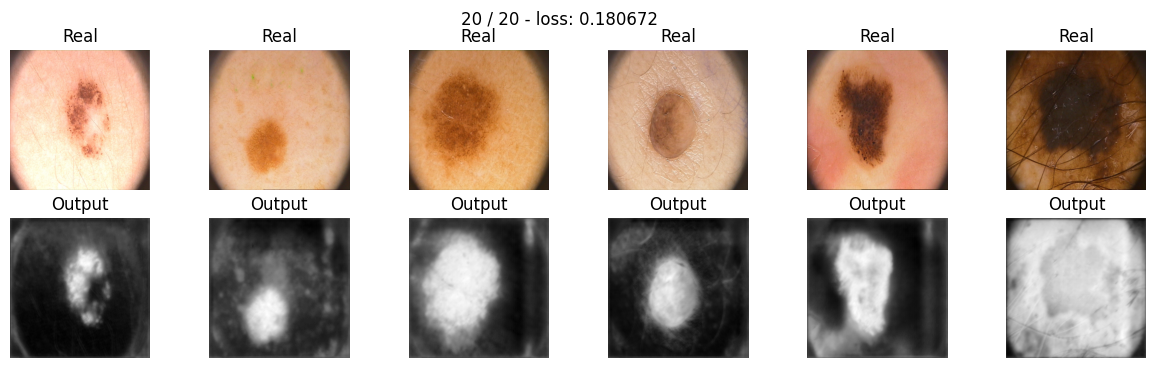

In [ ]:
model = UNet2().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.6239999979734421
Validation: 0.6240000128746033
Test: 0.5239999890327454


In [ ]:
res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'bce_loss',
                  'tr_loss': 0.624,	'val_loss': 0.624,	'ts_loss' : 0.524},
                  ignore_index = True)

<ipython-input-35-5d2bfbd1e0c0>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'bce_loss',


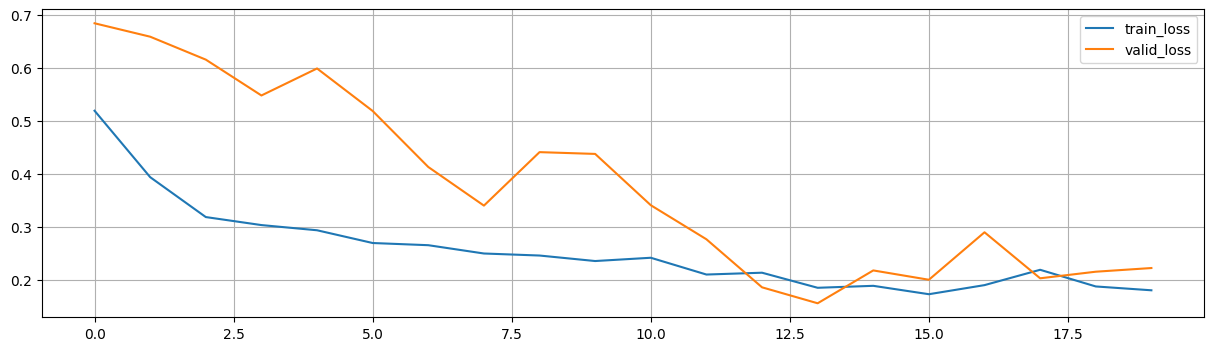

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

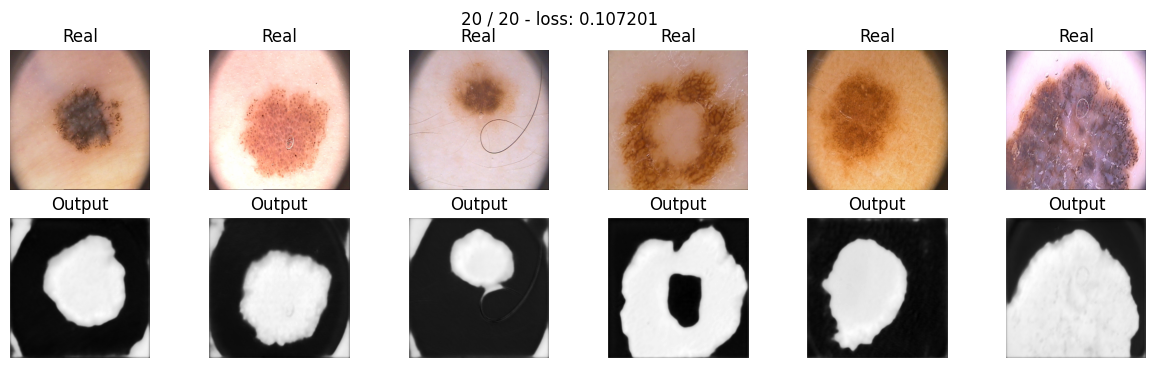

In [ ]:
model = UNet2().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.4139999821782112
Validation: 0.37199999392032623
Test: 0.32199999690055847


In [ ]:
res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'dice_loss',
                  'tr_loss': 0.414,	'val_loss': 0.372,	'ts_loss' : 0.322},
                  ignore_index = True)

<ipython-input-36-671b12be1a66>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'dice_loss',


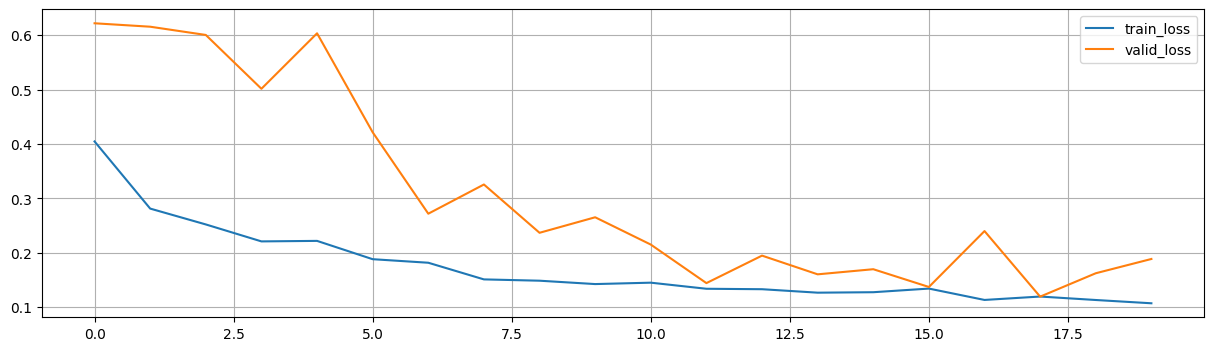

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

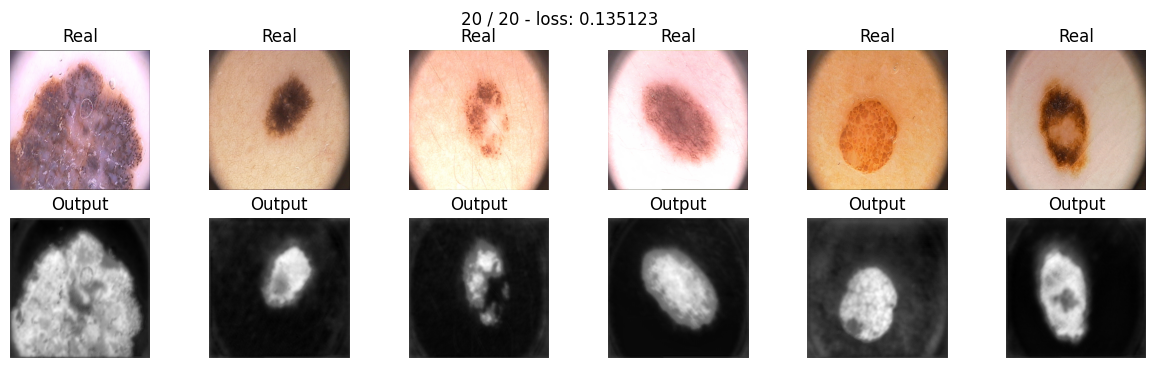

In [ ]:
model = UNet2().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.713000014424324
Validation: 0.706000030040741
Test: 0.6819999814033508


In [ ]:
res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'focal_loss',
                  'tr_loss': 0.713,	'val_loss': 0.706,	'ts_loss' : 0.682},
                  ignore_index = True)

<ipython-input-37-67420c532155>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'focal_loss',


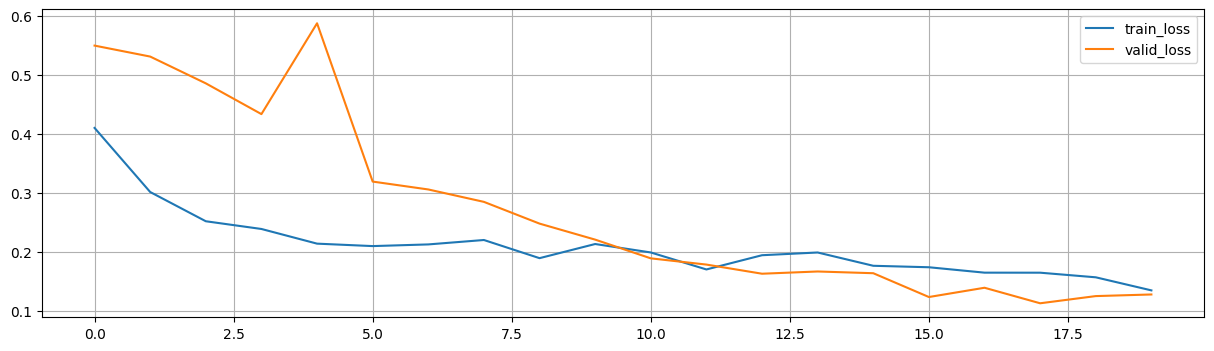

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

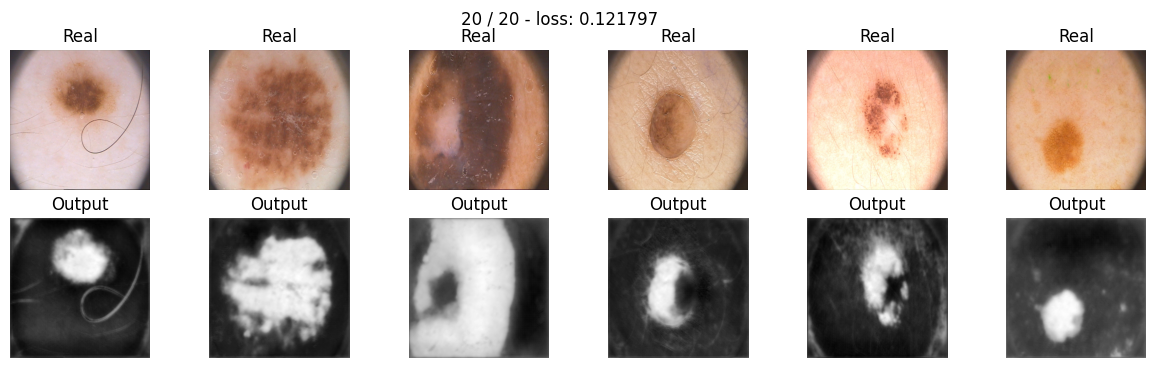

In [ ]:
model = UNet2().to(device)

max_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=3e-4)
tr_loss, val_loss = train(model, optimizer, ssim_loss, max_epochs, data_tr, data_val)

In [ ]:
print(f"Train: {score_model(model, iou_pytorch, data_tr)}")
print(f"Validation: {score_model(model, iou_pytorch, data_val)}")
print(f"Test: {score_model(model, iou_pytorch, data_ts)}")

Train: 0.5410000011324883
Validation: 0.6140000224113464
Test: 0.527999997138977


In [ ]:
res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'ssim_loss',
                  'tr_loss': 0.541,	'val_loss': 0.614,	'ts_loss' : 0.528},
                  ignore_index = True)

<ipython-input-38-97d0ec456cad>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_table = res_table.append({'Model' : 'UNet2', 'Loss func' : 'ssim_loss',


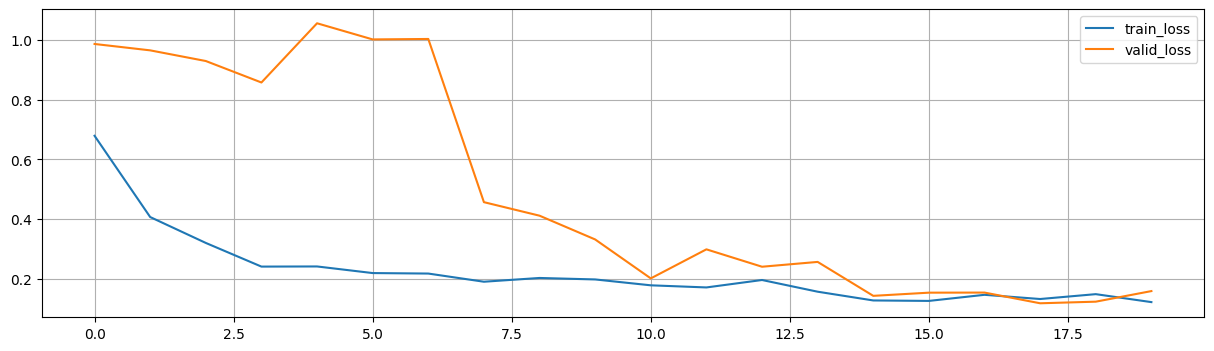

In [ ]:
epoch = range(len(tr_loss))
plt.plot(epoch, tr_loss, label='train_loss')
plt.plot(epoch, val_loss, label='valid_loss')
plt.grid()
plt.legend();

# Result

In [ ]:
res_table

Model   Loss func  tr_loss  val_loss  ts_loss
0   SegNet    bce_loss    0.876     0.714    0.678
1   SegNet   dice_loss    0.801     0.690    0.700
2   SegNet  focal_loss    0.690     0.620    0.602
3   SegNet   ssim_loss    0.619     0.660    0.580
4     UNet    bce_loss    0.685     0.638    0.558
5     UNet   dice_loss    0.612     0.646    0.582
6     UNet  focal_loss    0.706     0.736    0.646
7     UNet   ssim_loss    0.802     0.762    0.682
8    UNet2    bce_loss    0.624     0.624    0.524
9    UNet2   dice_loss    0.414     0.372    0.322
10   UNet2  focal_loss    0.713     0.706    0.682
11   UNet2   ssim_loss    0.541     0.614    0.528

According to the results of all training we can say that depending on the architecture of the model, different error functions are suitable. So for example dice_loss in SegNet showed itself best of all, and among all models and error functions. But on UNet and UNet 2 it, based on the tables, started to retrain closer to the 20th epoch, or on the contrary undertrained, i.e. you need more epochs to get a better result. Focal loss also works better with UNet and UNet2. It converged quite well and it could well be further trained on these models.

The ssim loss function showed itself most unequivocally, showing the 2nd best result on UNet. In principle, this loss function is quite flexible and has 6 hyperparameters, which will help to improve the final quality of the model.

bce loss on UNet and UNet2 was mostly retrained at epoch 20 and validation jumped to change its loss depending on the epoch